Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Szymon Budziak"
COLLABORATORS = ""

---

# Lab 3: State-space Models for Sequential Data

### Machine Learning 3 (2024)

* The deadline is Monday, October 27th, 23:59.
* Assignment should be submitted through Canvas! Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file should be "studentid\_lab#", for example, the attached file should be "12345\_lab3.ipynb". 

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the ```# YOUR CODE HERE``` comment and overwrite the ```raise NotImplementedError()``` line.
* Large parts of you notebook will be graded automatically. Therefore it is important that your notebook can be run completely without errors and within a reasonable time limit. To test your notebook before submission, select Kernel -> Restart \& Run All.

In [2]:
import matplotlib
import sys
import matplotlib.pyplot as plt
import numpy as np
import scipy
import csv
import IPython
from sklearn.cluster import KMeans

# Check whether the environment is correct
assert int(sys.version[0]) == 3 and int(sys.version[2]) == 8
assert matplotlib.__version__ == "3.5.2"
assert np.__version__ == "1.22.3"
assert scipy.__version__ == "1.9.0"
assert (
    IPython.version_info[0] >= 3
), "Your version of IPython is too old, please update it."

## Introduction
In this assignment, we will study two models for sequences: hidden Markov models (HMMs) and Kalman filters (KFs). Both models consist of latent states, which transition between time steps and observed variables, which are conditioned on the current latent state. 

We will first implement a hidden Markov model with discrete latent states and Gaussian emissions. We will apply this to the price of Bitcoin in USD and we will see if we can derive a trading strategy from the results of the model

All of the learning in this notebook is done via expectation-maximisation. If you feel like you need to read up on this, I recommend going through chapter 9 of Bishop. You should definitely consult chapter 13 of Bishop or the slides from lectures 9 and 10, since these cover the models that this notebook concerns itself with.

NB depending on which version of Bishop you are using, be ware of errata in the equations, see for instance https://www.microsoft.com/en-us/research/wp-content/uploads/2016/05/prml-errata-1st-20110921.pdf When in doubt about the equations in Bishop, note that the slides used in thise course are correct, and you can always fall back on those. I would suggest to not blindly implement the equations in Bishop that we refer to, but to make sure you double check using the course slides.

Finally, we would like to see nicely vectorised implementations for this notebook. This means that you will have to work with numpy arrays and perform many batched dot products and outer products. We provide some of the functions, but be sure that you are comfortable with numpy arrays and broadcasting. For example, we implement the batched outer product between two batched vectors $a$ and $b$ as follows:

``` python
def outer(a, b):
    return a[:, :, None] * b[:, None, :] 
```

## 1. Hidden Markov Model
Our HMM consists of categorical latent variables and Gaussian observables. The sequence is started by sampling a latent state from a prior distribution. This state then generates the first observable. A transition matrix $\mathbf{A}$ is applied to compute a probability distribution over the subsequent latent variable, which generates its own observable in turn. The full sequence is described by:

$$ 
p(\mathbf{X}, \mathbf{Z}|\mathbf{\Theta}) = p(\mathbf{z}_1|\mathbf{\pi}) \prod_{t=2}^T \left[ p(\mathbf{z}_n|\mathbf{z}_{n-1}, \mathbf{A})\right] \prod_{m=1}^T p(\mathbf{x}_m|z_{m}, \mathbf{\theta})
$$

Here the $\mathbf{z}$ denote a latent variable, $\mathbf{x}$ is an observable and $\mathbf{\theta}$ are the parameters of our Gaussian. If the one-hot latent variable $\mathbf{z}$ is equal to 1 at the kth position, the observable is drawn from:

$$
\mathbf{x} \sim \mathcal{N(\mathbf{x}|\mathbf{\mu}_k, \mathbf{\Sigma}_k)}.
$$

In the next block of code, we have implemented some functionality for a hidden Markov model. It will be your job to implement the forward-backward algorithm, the E & M steps and the Viterbi algorithm. Fortunately, the latter is much easier for the HMM than it was for a general factor graph. 

In [3]:
class HiddenMarkovModel:
    """Hidden Markov Model with categorical latents and Gaussian emission"""

    def __init__(self, d, k):
        self.d = d
        self.k = k
        self.pi, self.A, self.mu, self.S = self.init_params()

    def init_params(self):
        """Initialize HMM parameters"""
        # Probability over z1
        pi = np.random.random(self.k)
        pi /= pi.sum()

        # Transition matrix
        A = np.random.random((self.k, self.k))
        A /= A.sum(1, keepdims=True)

        # k mean vectors,
        mu = np.random.normal(size=(self.k, self.d)) / self.d

        # k covariances, initialised diagonally with unit determinant.
        S = np.zeros((self.k, self.d, self.d))
        for i in range(self.k):
            S[i] = np.diag(np.random.normal(0, 1, self.d))
            S[i] /= S[i].sum()
        return pi, A, mu, S

    def sample(self, T, show_id=False):
        """Sample a sequence from the HMM"""
        Z = np.zeros((T, self.k))
        X = np.zeros((T, self.d))
        Z[0] = np.random.multinomial(1, self.pi)
        idx = Z[0].argmax()
        X[0] = np.random.multivariate_normal(self.mu[idx], self.S[idx])

        for t in range(1, T):
            p = Z[t - 1] @ self.A
            Z[t] = np.random.multinomial(1, p)
            idx = Z[t].argmax()
            X[t] = np.random.multivariate_normal(self.mu[idx], self.S[idx])

        if show_id:
            return Z.argmax(1), X
        else:
            return X

    def compute_alpha(self, p_obs):
        """Forward pass"""
        raise NotImplementedError

    def compute_beta(self, p_obs, c):
        """Backward pass"""
        raise NotImplementedError

    def E_step(self, x):
        """Compute expectation under posteriors"""
        raise NotImplementedError

    def M_step(self, x, gamma, xi):
        """Maximise parameters"""
        raise NotImplementedError

    def viterbi(self, x):
        """Find most probable latent variables given sequence"""

        T = len(x)

        w = np.zeros((T, self.k))
        phi = np.zeros((T, self.k))
        log_p = gaussian(x, self.mu, self.S, log=True)
        log_A = np.log(self.A)

        w[0] = np.log(self.pi) + log_p[0]
        for t in range(1, T):
            w[t] = log_p[t] + np.max(log_A + w[t - 1][:, None], 0)
            phi[t] = np.argmax(log_A + w[t - 1][:, None], 0)

        zs = np.zeros((T, 1), dtype="int")
        zs[-1] = np.argmax(w[-1])
        for t in reversed(range(T - 1)):
            zs[t] = phi[t + 1][zs[t + 1]]
        return zs.squeeze()

    def fit(self, x, tol=1e-5):
        """Fit an HMM to data using EM"""
        LLs = []

        diff = tol + 1
        while diff > tol:
            gamma, xi, LL = self.E_step(x)
            self.M_step(x, gamma, xi)
            LLs.append(LL)

            if len(LLs) > 1:
                diff = LLs[-1] - LLs[-2]
        return LLs

We will provide you with several helper functions. The first, ``gaussian``, computes the pdf or logpdf of an observed sequence $\mathbf{X}$ given parameters $\{\mu_k\}$ and $\{\Sigma_k\}$. The next one, ``plot_sequence``, allows us to plot a trajectory for an HMM and show where each component originated if we provide the latent variables. 

In [4]:
def gaussian(x, mu, S, log=False):
    """
    Based on the scipy implementation.
    x  -> [T, d]
    mu -> [(k), d]
    S  -> [(k), d, d]
    returns -> [T, (k)]
    """
    vals, vecs = np.linalg.eigh(S)

    # k=1
    if len(S.shape) == 2:
        d = mu.shape[0]
        logdet = np.log(vals).sum()
        U = vecs * np.sqrt(1 / vals)
        dev = x - mu[None, :]
        maha = np.square(dev @ U).sum(1)
        log2pi = np.log(2 * np.pi)
        logpdf = -0.5 * (d * log2pi + maha + logdet)

    # k > 1
    elif len(S.shape) == 3:
        k, d = mu.shape
        logdet = np.log(vals).sum(1)
        U = vecs * np.sqrt(1 / vals)[:, None, :]
        dev = x[:, None, :] - mu[None, :, :]
        maha = np.einsum("Tkj, kjd->Tkd", dev, U)
        maha = np.square(maha).sum(2)
        log2pi = np.log(2 * np.pi)
        logpdf = -0.5 * (d * log2pi + maha + logdet[None, :])

    if log:
        return logpdf
    else:
        return np.exp(logpdf)

In [5]:
def outer(a, b):
    """Compute (batched) outer product"""
    assert len(a.shape) == len(b.shape), "Invalid combination of shapes"
    assert a.shape[:-1] == b.shape[:-1], "Invalid shapes"
    return a[..., :, None] * b[..., None, :]

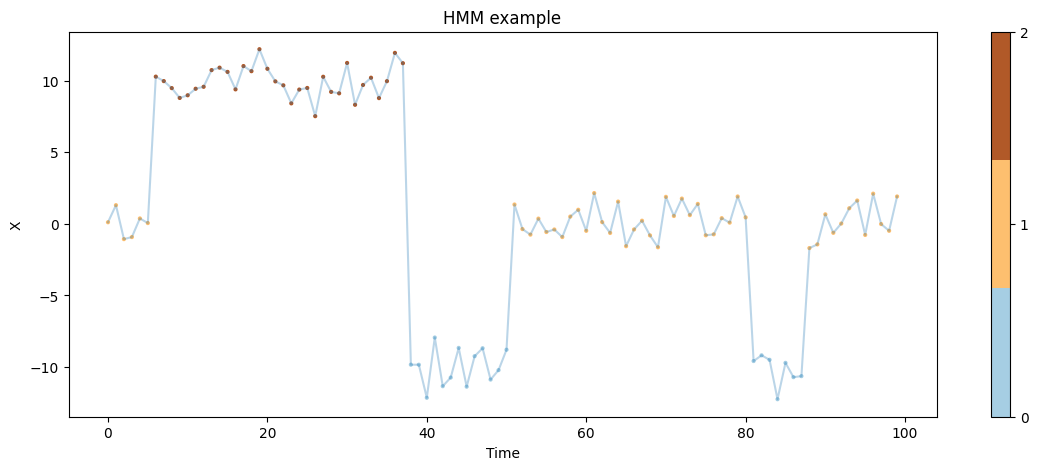

In [6]:
def plot_sequence(X, Z=None, k=None, ylabel=None, title=None):
    """Plot HMM sequence with 1D observables"""
    assert X.shape[1] == 1
    T = list(range(len(X)))

    plt.figure(figsize=(14, 5))
    cmap = plt.get_cmap("Paired", k)
    plt.plot(T, X, alpha=0.3)
    if Z is None:
        plt.scatter(T, X, s=4, cmap=cmap)
    else:
        plt.scatter(T, X, s=4, c=Z, cmap=cmap)
        plt.colorbar(ticks=np.arange(np.min(Z), k + 1))
    plt.xlabel("Time")

    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.show()


np.random.seed(729)
N = 100
d = 1
k = 3
hmm = HiddenMarkovModel(d, k)

# Set some pretty parameters.
mu = np.array([-10, 0, 10])[:, None]
A = np.eye(k) + np.random.random((k, k)) * 0.1
A /= A.sum(1, keepdims=True)
hmm.mu = mu
hmm.A = A

Z, X = hmm.sample(N, show_id=True)
plot_sequence(X, Z, k, "X", "HMM example")

### 1.1 Forward pass: computing $\hat{\alpha}$
Make sure that you have read through sections 13.2.2-13.2.4 of Bishop, especially the last section on scaling factors. This will allow our computation to be numerically stable, which is of great importance for even short sequences. 

Complete the function ``compute_alpha(self, p_obs)``, which computes the normalised alpha coeffients given the Gaussian pdf of the sequence. The coefficients $c_n$ can be easily computed by summing over the $k$-axis in $\alpha_n$, since it is the coefficient that normalises the distribution. 

The function should return $\hat{\alpha}(\mathbf{z}_n)$ and $c_n$ for the entire sequence as numpy arrays.

---
#### $\alpha$ formula

$$
\alpha(z_n) = p(x_n|z_n) * \sum_{z_{n-1}} \alpha(z_{n-1}) * p(z_n|z_{n-1})
$$

In [7]:
def compute_alpha(self, p_obs: np.ndarray) -> "tuple[np.ndarray, np.ndarray]":
    """
    Compute the forward probabilities (alpha) and scaling factors (c) for a given observed probabilities.

    Args:
        p_obs (np.ndarray): The observed probabilities of the HMM. Shape (T, k).

    Returns:
        tuple[np.ndarray, np.ndarray]: The forward probabilities (alpha) and scaling factors (c). Shapes (T, k) and (T, 1) respectively.
    """
    # YOUR CODE HERE
    T, k = p_obs.shape

    # Initialize alpha and c
    alpha = np.zeros(shape=(T, k))
    c = np.zeros(shape=(T, 1))

    # Initialize alpha and c for n = 1
    alpha[0] = self.pi * p_obs[0]
    c[0] = np.sum(alpha[0])
    alpha[0] /= c[0]  # Normalize alpha[0]

    # Recursion (for n=2 to T)
    for t in range(1, T):
        # Compute alpha values and scaling factor for this time step
        alpha[t] = p_obs[t] * (alpha[t - 1] @ self.A)
        c[t] = np.sum(alpha[t])
        alpha[t] /= c[t]

    return alpha, c

In [8]:
HiddenMarkovModel.compute_alpha = compute_alpha


def test_hmm():
    """Create dummy model for testing"""
    T = 10
    d = 1
    k = 3
    np.random.seed(121)
    hmm = HiddenMarkovModel(d, k)
    return hmm, hmm.sample(T)


hmm, X = test_hmm()
p_obs = gaussian(X, hmm.mu, hmm.S)
alpha, c = hmm.compute_alpha(p_obs)

assert alpha.shape == (len(X), hmm.k)
assert c.shape == (len(X), 1)
assert np.allclose(
    alpha.sum(1), np.ones(len(alpha))
), "Make sure you have normalised your alphas"

### 1.2 Backward pass: computing $\hat{\beta}$
Next, we iterate backwards over the sequence to compute $\hat{\beta}(\mathbf{z}_n)$. Complete the function ``compute_beta``, which takes as input the Gaussian pdf of the observables and the previously computed constants $c_n$, which we re-use here. The function should return an array with the normalised beta coefficients. 

Unfortunately, there does not exist a nice test as the one we had for alpha, since the beta coefficients are a ratio of probabilities. 

***Hint:*** Bishop is not very explicit on this, but $\hat{\beta}(\mathbf{z}_N)$—the starting value—is a vector of ones. 

---
#### $\beta$ formula

$$
\beta(z_n) = \sum_{z_{n+1}} \beta(z_{n+1}) * p(x_{n+1}|z_{n+1}) * p(z_{n+1}|z_n)
$$

In [9]:
def compute_beta(self, p_obs: np.ndarray, c: np.ndarray) -> np.ndarray:
    """
    Compute the backward probabilities (beta) for a given observed probabilities and scaling factors.

    Args:
        p_obs (np.ndarray): The observed probabilities of the HMM. Shape (T, k).
        c (np.ndarray): The scaling factors computed in the forward pass. Shape (T, 1).

    Returns:
        np.ndarray: The backward probabilities (beta). Shape (T, k).
    """
    # YOUR CODE HERE
    T, k = p_obs.shape

    # Initialize beta values
    # Thanks to ones initialization, we can skip bet[-1] = 1
    beta = np.ones(shape=(T, k))

    # Recursion (for n=T-1 to 1)
    for t in reversed(range(T - 1)):
        beta[t] = self.A @ (p_obs[t + 1] * beta[t + 1])
        beta[t] /= c[t + 1]  # Normalize with the scaling factor for numerical stability

    return beta

In [10]:
HiddenMarkovModel.compute_beta = compute_beta

hmm, X = test_hmm()
p_obs = gaussian(X, hmm.mu, hmm.S)
alpha, c = hmm.compute_alpha(p_obs)
beta = hmm.compute_beta(p_obs, c)

assert beta.shape == (len(X), hmm.k)
assert np.allclose(beta[-1], np.ones(hmm.k)), "Check your starting value"

### 1.3 E-step: computing $\gamma$ and $\xi$
Next, we apply equations (13.64) and (13.65) in bishop to compute the responsibilities and transitions, which are the values we need for the E-step in the EM algorithm. 

Implement the function ``E_step``, which takes in the observations, computes ``p_obs``, ``alpha``, ``c`` and ``beta`` and uses these variables to compute $\gamma(\mathbf{z}_n)$ and $\xi(\mathbf{z}_{n-1}, \mathbf{z}_n)$ and the log-likelihood of the observations. We will use this to monitor the convergence of the EM algorithm. 

---
#### $\gamma$ formula

$$
\gamma(z_n) = \hat{\alpha}(z_n) * \hat{\beta}(z_n)
$$

#### $\xi$ formula

$$
\xi(z_{n-1}, z_n) = \frac{\hat{\alpha}(z_{n-1}) * p(x_n|z_n) * p(z_n|z_{n-1}) * \hat{\beta}(z_n)}{c_n}
$$

In [26]:
def E_step(self, X: np.ndarray) -> "tuple[np.ndarray, np.ndarray, float]":
    """
    Performs the E-step to calculate responsibilities and log-likelihood.

    Args:
        X (np.ndarray): The observed data. Shape (T, d).

    Returns:
        tuple[np.ndarray, np.ndarray, float]: The responsibilities (gamma), transition values (xi), and log-likelihood (LL).
    """
    # YOUR CODE HERE
    T = X.shape[0]

    # Compute the observation probabilities (Gaussian pdf)
    p_obs = gaussian(X, self.mu, self.S)

    # Run forward and backward passes to compute alpha, beta, and c
    alpha, c = self.compute_alpha(p_obs)
    beta = self.compute_beta(p_obs, c)

    # Compute gamma (responsibilities) using normalized alpha and beta
    gamma = alpha * beta

    # Compute xi (transition values) for each pair of consecutive time steps
    xi = np.zeros(shape=(T - 1, self.k, self.k))

    for t in range(T - 1):
        xi[t] = (alpha[t][:, None] * p_obs[t + 1] * self.A * beta[t + 1]) / c[t + 1]

    # Compute log-likelihood from the scaling factors
    LL = np.sum(np.log(c))

    return gamma, xi, LL

In [27]:
HiddenMarkovModel.E_step = E_step

hmm, X = test_hmm()
gamma, xi, LL = hmm.E_step(X)

assert gamma.shape == (len(X), hmm.k)
assert xi.shape == (len(X) - 1, hmm.k, hmm.k)
assert LL.shape == ()

assert np.allclose(gamma.sum(1), np.ones(len(X))), "Gamma isn't normalised!"
assert np.allclose(xi.sum((1, 2)), np.ones(len(X) - 1)), "Xi isn't normalised!"

### 1.4 M-step: update the parameters!

We're finally there! Implement the function ``M_step``, that takes in the observed sequence ``X`` and the two variables computed by the E-step and update the parameters of your model. The updates are described in (13.18-13.21) in Bishop. I would like to see a nice, vectorised update, so please refrain from looping over the clusters $k$.

The function does not need to return anything, it should merely update the parameters of the model. 

**Hint:** Use the previously defined function ``outer`` to compute batched outer products

---
#### $\pi$ update formula

$$
\pi_k = \frac{\gamma(z_{1k}) }{\sum_{j=1}^K \gamma(z_{1j})}
$$

#### $A_{jk}$ update formula

$$
A_{jk} = \frac{\sum_{n=2}^N \xi(z_{n-1, j}, z_{nk})}{\sum_{l=1}^K \sum_{n=2}^N \xi(z_{n-1, j}, z_{nl})}
$$

#### $\mu$ update formula

$$
\mu_k = \frac{\sum_{n=1}^N \gamma(z_{nk}) * x_n}{\sum_{n=1}^N \gamma(z_{nk})}
$$

#### $\Sigma$ update formula

$$
\Sigma_k = \frac{\sum_{n=1}^N \gamma(z_{nk}) * (x_n - \mu_k)(x_n - \mu_k)^T}{\sum_{n=1}^N \gamma(z_{nk})}
$$

In [28]:
def M_step(self, x, gamma, xi):
    """
    Performs the M-step that maximizes the parameters of the HMM.

    Args:
        x (np.ndarray): The observed data. Shape (T, d).
        gamma (np.ndarray): The responsibilities. Shape (T, k).
        xi (np.ndarray): The transition values. Shape (T-1, k, k).
    """
    # YOUR CODE HERE
    _, d = x.shape
    _, k = gamma.shape

    # Update initial state distribution pi
    self.pi = gamma[0] / np.sum(gamma[0])

    # Update transition matrix A
    self.A = np.sum(xi, axis=0) / np.sum(xi, axis=(0, 2))[:, None]

    # Update mu
    # Sum of responsibilities for each state k
    gamma_sum = np.sum(gamma, axis=0)
    self.mu = (gamma.T @ x) / gamma_sum[:, None]

    # Update covariance matrices S
    x_centered = x[:, None, :] - self.mu
    outer_x = outer(x_centered, x_centered)
    self.S = (
        np.sum(gamma[:, :, None, None] * outer_x, axis=0) / gamma_sum[:, None, None]
    )

In [29]:
HiddenMarkovModel.M_step = M_step

hmm, X = test_hmm()
gamma, xi, LL = hmm.E_step(X)
hmm.M_step(X, gamma, xi)

d = hmm.d
k = hmm.k

pi, A, mu, S = hmm.pi, hmm.A, hmm.mu, hmm.S

assert pi.shape == (k,)
assert A.shape == (k, k)
assert mu.shape == (k, d)
assert S.shape == (k, d, d)

assert np.allclose(pi.sum(), 1), "Your prior is no longer normalised"
assert np.allclose(
    A.sum(1), np.ones(k)
), "The transition matrix is no longer stochastic"
assert np.allclose(
    S, S.transpose(0, 2, 1)
), "Your covariance matrices are non-symmetric"
assert np.all(
    np.linalg.det(S) > 0
), "Your covariance matrix are not positive semi-definite"

## 1.5 Bitcoin
I thought it would be nice to have a real-world example of what you can use a hidden Markov model for. Note that this section should under no circumstance be interpreted as sound financial advice, unless you aim to lose your money rather quickly. 

The following function loads the adjusted closing price of Bitcoin in US dollars at the end of every trading day. This data runs from September 2014 until October 2022, when this notebook was created. We can see some interesting peaks when the BTC bubble was at its highest. 

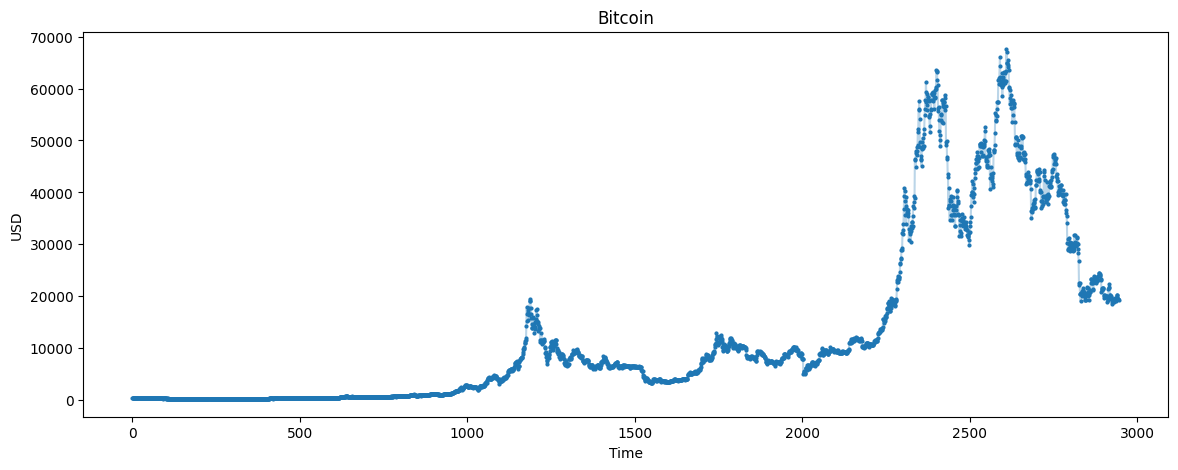

In [30]:
def load_btc_data(path):
    with open(path, newline="") as csvfile:
        reader = csv.reader(csvfile, delimiter=" ", quotechar="|")
        reader.__next__()

        dates = []
        prices = []
        for row in reader:
            row = row[0].split(",")
            dates.append(row[0])
            prices.append(float(row[5]))

    return dates, np.array(prices)[:, None]


dates, prices = load_btc_data("BTC-USD.csv")

plot_sequence(prices, ylabel="USD", title="Bitcoin")

We will try to model the market using three clusters. I want you to write a function ``invest``, that invests based on the clustering results. Let's assume that you start with 100 dollars at timestep 2000 and you invest it all in bitcoin. You must cash out at timestep 2900. Can you increase your wealth when basing your decisions only on the state of the market $\mathbf{z}_n$? 

We will train our model on the relative price difference between the current and the previous day. We'll also normalise this data. See the next cell for details. 

In order to avoid instabilities and speed up training, we will initialise the Gaussian covariances and means to match those of the data. You can re-train your hmm every day on the longer sequence without re-initialising the parameters. Use the Viterbi algorithm to determine the state of the market and buy or sell based on that!

***Hint:*** the order of clusters changes between different initialisations. Make sure you identify the clusters based on their means/covariances

/var/folders/53/ldcvn1sj4js351r490m019y40000gn/T/ipykernel_81731/1632048358.py:74: RuntimeWarning: divide by zero encountered in log
  w[0] = np.log(self.pi) + log_p[0]


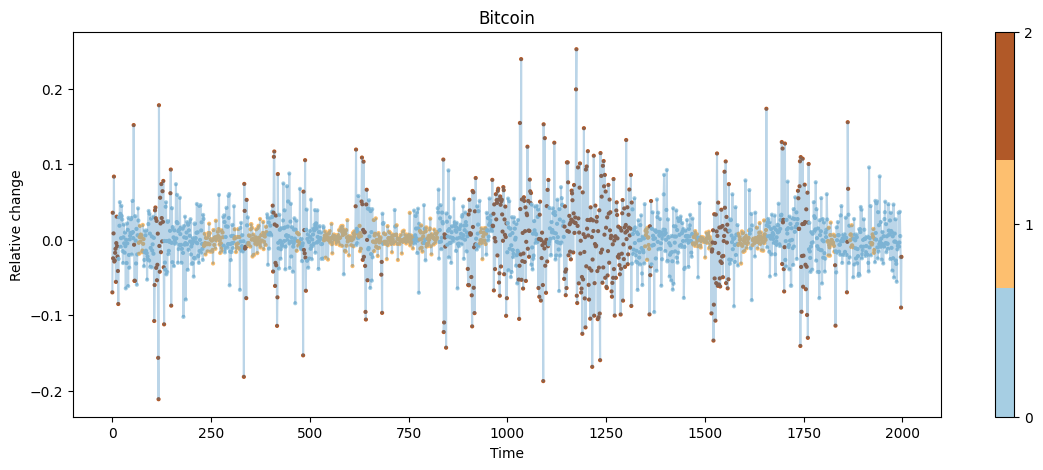

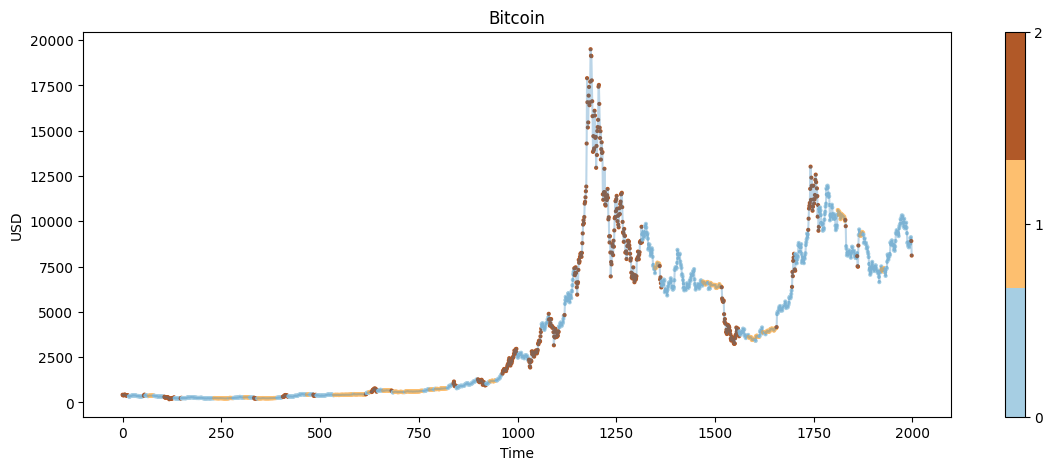

In [31]:
d = 1
k = 3
T_start = 2000
T_end = 2900

delta_prices = (prices - np.roll(prices, 1, 0))[1:] / prices[:-1]


hmm = HiddenMarkovModel(1, k)

kmeans = KMeans(k)
kmeans.fit(delta_prices[:T_start])
hmm.mu = kmeans.cluster_centers_
hmm.S = np.repeat(np.cov(delta_prices[:T_start].T), k)[:, None, None]

hmm.fit(delta_prices[:T_start])
Z = hmm.viterbi(delta_prices[1:T_start])

plot_sequence(delta_prices[1:T_start], Z, k, ylabel="Relative change", title="Bitcoin")

plot_sequence(prices[1:T_start], Z, k, ylabel="USD", title="Bitcoin")

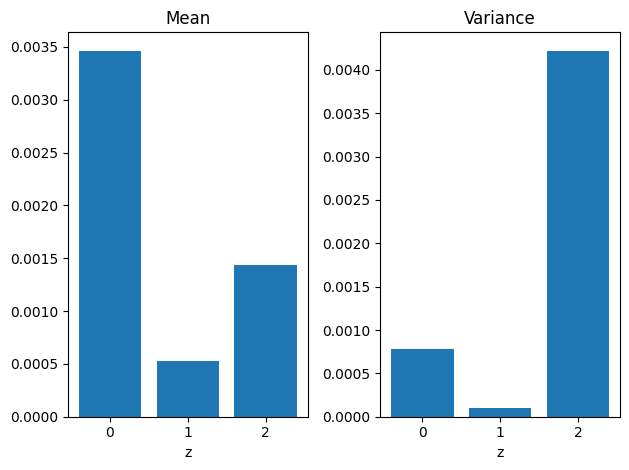

In [32]:
def plot_params(hmm):
    plt.figure()
    plt.subplot(121)
    plt.title("Mean")
    plt.bar(list(range(hmm.k)), hmm.mu.flatten())
    plt.xlabel("z")

    plt.subplot(122)
    plt.title("Variance")
    plt.bar(list(range(hmm.k)), hmm.S.flatten())
    plt.xlabel("z")
    plt.tight_layout()
    plt.show()


plot_params(hmm)

Try and figure out a winning strategy! Be sure **not** to retrain the model on every new observation, just call the Viterbi algorithm and determine the state of the latest data point.

In [33]:
def invest(hmm, prices, delta_prices, T_start, T_end):
    # YOUR CODE HERE
    money, bitcoin = 100, 0

    initial_states = hmm.viterbi(delta_prices[1:T_start])
    state_returns = [
        np.sum(delta_prices[1:T_start][initial_states == i]) for i in range(hmm.k)
    ]

    percent_invest = 0.1
    for t in range(T_start, T_end):
        current_price = prices[t][0]

        # Shorter window for state identification
        start_idx = max(1, t - 50)
        current_state = hmm.viterbi(delta_prices[start_idx : t + 1])[-1]

        if state_returns[current_state] > 0 and money > 0:
            bitcoin += money * percent_invest / current_price
            money *= 1 - percent_invest
        elif state_returns[current_state] < 0 and bitcoin > 0:
            money += bitcoin * percent_invest * current_price
            bitcoin *= 1 - percent_invest

        # Use new info to update state statistics
        state_returns[current_state] += delta_prices[t]

    money += bitcoin * current_price
    bitcoin = 0
    return money


money = invest(hmm, prices, delta_prices, T_start, T_end)

if money > 100:
    print("Earned:", money - 100, "USD")
else:
    print("Lost:", 100 - money, "USD")

/var/folders/53/ldcvn1sj4js351r490m019y40000gn/T/ipykernel_81731/1632048358.py:74: RuntimeWarning: divide by zero encountered in log
  w[0] = np.log(self.pi) + log_p[0]


Earned: 247.64721444301256 USD


## 2. Kalman Filters
The next model is similar to the HMM, its only difference being a continuous (Gaussian) latent variable. Kalman filters are useful for smoothing noisy trajectories, finding applications in the [Apollo program](https://ntrs.nasa.gov/api/citations/19860003843/downloads/19860003843.pdf) among others. We will use Kalman filters to smooth the noisy trajectory of a Lorentz attractor. 

The following code implements—again—a framework that you will have to fill in. Our ``KalmanFilter`` class implements a sampling procedure, but you will have to provide the equations to do inference. 

In [100]:
class KalmanFilter:
    """Kalman Filter with built-in EM algorithm"""

    def __init__(self, d_obs, d_latent):
        self.d_obs = d_obs
        self.d_latent = d_latent

        self.A = np.eye(d_latent)
        self.G = np.eye(d_latent)
        self.C = np.eye(d_obs, d_latent)
        self.S = np.eye(d_obs)

        self.mu0 = np.zeros(d_latent)
        self.P0 = np.eye(d_latent)

    def sample(self, T, show_id=False):
        """Sample a trajectory"""
        z = np.zeros((T, self.d_latent))
        x = np.zeros((T, self.d_obs))

        z[0] = np.random.multivariate_normal(self.mu0, self.P0)
        x[0] = np.random.multivariate_normal(self.C @ z[0], self.S)
        for t in range(1, T):
            z[t] = np.random.multivariate_normal(self.A @ z[t - 1], self.G)
            x[t] = np.random.multivariate_normal(self.C @ z[t - 1], self.S)
        if show_id:
            return z, x
        else:
            return x

    def smooth(self, X):
        """Smooth a trajectory X"""
        mu, V, c, P = kf.forward(X)
        mu_hat, V_hat, J = kf.backward(mu, V, P)
        X_rec = mu_hat @ kf.C.T
        return X_rec

    def compute_P(self, V):
        raise NotImplementedError

    def compute_K(self, P):
        raise NotImplementedError

    def forward(self, x):
        """Forward pass"""
        raise NotImplementedError

    def backward(self, mu, V, P):
        """Backward pass"""
        raise NotImplementedError

    def E_step(self, x):
        """Run E-step"""
        raise NotImplementedError

    def M_step(self, x, Ez, Ezzp, Ezz):
        """Run M-step"""

    def fit(self, x, tol=1e-5):
        """Fit Kalman Filter to data"""
        LLs = []
        diff = tol + 1
        while diff > tol:
            Ez, Ezzp, Ezz, LL = self.E_step(x)
            self.M_step(x, Ez, Ezzp, Ezz)

            LLs.append(LL)
            if len(LLs) > 1:
                diff = LLs[-1] - LLs[-2]
        return LLs

### 2.1 Forward pass
Compute the forward pass through the model using equations (13.88-13.97) in Bishop. Write the functions ``compute_P``, ``compute_K`` and ``forward``. The latter should return ``mu, V, c, P``. 

**Hint:** Since $\mathbf{P}_{n-1}$ is indexed by $n-1$, the array will be one element shorter than the length of the sequence. Don't include the parameter $\mathbf{P}_0$ in this array!

---
#### $P_{n-1}$ formula

$$
\mathbf{P}_{n-1} = \mathbf{A} \mathbf{V}_{n-1} \mathbf{A}^T + \mathbf{G}
$$

#### $K_n$ formula

$$
\mathbf{K}_n = \mathbf{P}_{n-1} \mathbf{C}^T (\mathbf{C} \mathbf{P}_{n-1} \mathbf{C}^T + \mathbf{S})^{-1}
$$

#### Forward formula

Initial values:

$$
\mathbf{K}_1 = \mathbf{P}_0 \mathbf{C}^T (\mathbf{C} \mathbf{P}_0 \mathbf{C}^T + \mathbf{S})^{-1} \\
\mathbf{\mu}_1 = \mathbf{\mu}_0 + \mathbf{K}_1 (\mathbf{x}_1 - \mathbf{C} \mathbf{\mu}_0) \\
\mathbf{V}_1 = (I - \mathbf{K}_1 \mathbf{C}) \mathbf{P}_0 \\
\mathbf{c}_1 = \mathcal{N}(\mathbf{x}_1|\mathbf{C} \mathbf{\mu}_0, \mathbf{C} \mathbf{P}_0 \mathbf{C}^T + \mathbf{S}) \\
$$

Updates in iteration:

$$
\mathbf{P}_{n-1} \\
\mathbf{K}_n\\
\mathbf{\mu}_n = \mathbf{A} \mathbf{\mu}_{n-1} + \mathbf{K}_n (\mathbf{x}_n - \mathbf{C} \mathbf{A} \mathbf{\mu}_{n-1}) \\
\mathbf{V}_n = (I - \mathbf{K}_n \mathbf{C}) \mathbf{P}_{n-1} \\
\mathbf{c}_n = \mathcal{N}(\mathbf{x}_n|\mathbf{C}\mathbf{A}\mathbf{\mu}_{n-1}, \mathbf{C} \mathbf{P}_{n-1} \mathbf{C}^T + \mathbf{S}) \\
$$

In [122]:
import scipy.stats


def compute_P(self, V: np.ndarray) -> np.ndarray:
    """
    Compute Prediction covariance P. Eq. (13.88) from Bishop.

    Args:
        V (np.ndarray): Covariance matrix from the previous time step.

    Returns:
        np.ndarray: Prediction covariance P.
    """
    # YOUR CODE HERE
    return self.A @ V @ self.A.T + self.G


def compute_K(self, P: np.ndarray) -> np.ndarray:
    """
    Compute Kalman gain K. Eq. (13.92) from Bishop.

    Args:
        P (np.ndarray): Prediction covariance P.

    Returns:
        np.ndarray: Kalman gain K.
    """
    # YOUR CODE HERE
    return P @ self.C.T @ np.linalg.inv(self.C @ P @ self.C.T + self.S)


def forward(
    self, X: np.ndarray
) -> "tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]":
    """
    Compute the forward pass of the Kalman filter.

    Args:
        X (np.ndarray): The observed data. Shape (T, d_obs).

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: State mean estimates (mu), state covariance estimates (V), normalizing/scaling factors (c), predicted state covariance estimates
    """
    # YOUR CODE HERE
    T = len(X)

    mu = np.zeros(shape=(T, self.d_latent))  # State mean estimates
    V = np.zeros(shape=(T, self.d_latent, self.d_latent))  # State covariance estimates
    P = np.zeros(
        shape=(T - 1, self.d_latent, self.d_latent)
    )  # Predicted state covariance estimates
    c = np.zeros(shape=(T, 1))  # Normalizing/Scaling factors

    # Initialize K, mu_0, V_0, c_0
    K = self.compute_K(self.P0)  # eq. (13.97)
    mu[0] = self.mu0 + K @ (X[0] - self.C @ self.mu0)  # eq. (13.94)
    V[0] = (np.eye(self.d_latent) - K @ self.C) @ self.P0  # eq. (13.95)
    c[0] = gaussian(
        X[0], self.C @ self.mu0, self.C @ self.P0 @ self.C.T + self.S
    )  # eq. (13.96)

    # Forward pass (for n=2 to T)
    for t in range(1, T):
        # Prediction step
        P[t - 1] = self.compute_P(V[t - 1])  # eg. (13.88)

        # Kalman gain
        K = self.compute_K(P[t - 1])  # eq. (13.92)

        # Update mean, covariance and scaling factor
        mu_pred = self.A @ mu[t - 1]
        innovation = X[t] - self.C @ mu_pred
        mu[t] = mu_pred + K @ innovation  # eq. (13.89)

        V[t] = (np.eye(self.d_latent) - K @ self.C) @ P[t - 1]  # eq. (13.90)

        c[t] = scipy.stats.multivariate_normal.pdf(
            X[t],
            mean=self.C @ mu_pred,
            cov=self.C @ P[t - 1] @ self.C.T + self.S,
        )  # eq. (13.91)

    return mu, V, c, P

In [123]:
def test_kf():
    """Create dummy model for testing"""
    T = 10
    d_obs = 3
    d_latent = 2
    np.random.seed(121)
    kf = KalmanFilter(d_obs, d_latent)
    return kf, kf.sample(T)


KalmanFilter.compute_P = compute_P
KalmanFilter.compute_K = compute_K
KalmanFilter.forward = forward
kf, X = test_kf()
mu, V, c, P = kf.forward(X)

assert mu.shape == (len(X), kf.d_latent)
assert V.shape == (len(X), kf.d_latent, kf.d_latent)
assert c.shape == (len(X), 1)
assert P.shape == (len(X) - 1, kf.d_latent, kf.d_latent)

### 2.2 Backward pass
Next, use equations (13.100-13.102) to compute the backward pass for the Kalman filter. Complete the function ``backward``, which returns ``mu_hat, V_hat, J``. 

**Hint1:** Use $\hat{\mathbf{\mu}}_N = \mathbf{\mu}_N$ and $\hat{\mathbf{V}}_N = \mathbf{V}_N$ as starting values for the backward recursion.

**Hint2:** Like $P$, the array $J$ will be one shorter than the length of the sequence.

**Hint3:** You can batch-invert in numpy. This means you only have to call the inversion once before the start of the for loop. 

---
#### Backward formula

$$
\hat{\mathbf{\mu}}_n = \mathbf{\mu}_n + \mathbf{J}_n (\hat{\mathbf{\mu}}_{n+1} - \mathbf{A} \mathbf{\mu}_n) \\
\hat{\mathbf{V}}_n = \mathbf{V}_n + \mathbf{J}_n (\hat{\mathbf{V}}_{n+1} - \mathbf{P}_n) \mathbf{J}_n^T \\
\mathbf{J}_n = \mathbf{V}_n \mathbf{A}^T \mathbf{P}_n^{-1}
$$

In [103]:
def backward(
    self, mu: np.ndarray, V: np.ndarray, P: np.ndarray
) -> "tuple[np.ndarray, np.ndarray, np.ndarray]":
    """
    Compute the backward pass of the Kalman filter.

    Args:
        mu (np.ndarray): mean from the forward pass at time step n. Shape (T, d_latent).
        V (np.ndarray): covariance matrix from the forward pass at time step n. Shape (T, d_latent, d_latent).
        P (np.ndarray): prediction covariance matrix from the forward pass at time step n. Shape (T-1, d_latent, d_latent).

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray]: smoothed mean estimates (mu_hat), smoothed covariance estimates (V_hat), smoothing gain (J).
    """
    # YOUR CODE HERE
    T = mu.shape[0]

    # Initialize arrays to store smoothed estimates
    mu_hat = np.zeros_like(mu)
    V_hat = np.zeros_like(V)
    J = np.zeros(shape=(T - 1, self.d_latent, self.d_latent))

    # Set the last time step estimates as the starting point for backward pass
    mu_hat[-1] = mu[-1]
    V_hat[-1] = V[-1]

    # Precompute P inversion for batch efficiency
    P_inv = [np.linalg.inv(P[t]) for t in range(T - 1)]

    # Backward pass (starting from the second last time step)
    for t in range(T - 2, -1, -1):
        # Compute J_n
        J[t] = V[t] @ self.A.T @ P_inv[t]  # eq. (13.102)

        # Compute smoothed mean
        mu_hat[t] = mu[t] + J[t] @ (mu_hat[t + 1] - self.A @ mu[t])  # eq. (13.100)

        # Compute smoothed covariance
        V_hat[t] = V[t] + J[t] @ (V_hat[t + 1] - P[t]) @ J[t].T  # eq. (13.101)

    return mu_hat, V_hat, J

In [104]:
KalmanFilter.backward = backward
kf, X = test_kf()
mu, V, c, P = kf.forward(X)
mu_hat, V_hat, J = kf.backward(mu, V, P)

assert mu_hat.shape == (len(X), kf.d_latent)
assert V_hat.shape == (len(X), kf.d_latent, kf.d_latent)
assert J.shape == (len(X) - 1, kf.d_latent, kf.d_latent)

### 2.3 E-step
Now that you have completed the forward and backward pass, you can compute the expectations in (13.105-13.107). You can use ``np.roll(J, shift, axis)`` to compare two arrays at different indices. Be sure to remove the values that loop around though! 

The method ``E_step`` receives the observation $\mathbf{X}$ and calls the forward and backward methods to get all the variables necessary to compute ``Ez, Ezzp, Ezz, LL``, the latter being the log-likelihood of the observed sequence. This is so that the ``fit`` method can simply alternate between calling ``E_step`` and ``M_step``. 

**Hint:** use the previously defined function ``outer`` to compute batched outer products.

---
#### E-step formula

$$
\mathbb{E}[z_n] = \hat{\mathbf{\mu}}_n \\
\mathbb{E}[z_n z_{n-1}^T] = \hat{\mathbf{V}}_n \mathbf{J}_{n-1}^T + \hat{\mathbf{\mu}}_n \hat{\mathbf{\mu}}_{n-1}^T \\
\mathbb{E}[z_n z_n^T] = \hat{\mathbf{V}}_n + \hat{\mathbf{\mu}}_n \hat{\mathbf{\mu}}_n^T \\
$$

In [105]:
def E_step(self, x: np.ndarray) -> "tuple[np.ndarray, np.ndarray, np.ndarray, float]":
    """
    Compute the E-step of the Kalman filter.

    Args:
        x (np.ndarray): The observed data. Shape (T, d_obs).

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray, float]: State mean estimates (Ez), transition values (Ezzp), state covariance estimates (Ezz), log-likelihood (LL).
    """
    # YOUR CODE HERE
    # Perform the forward and backward passes
    mu, V, c, P = self.forward(x)
    mu_hat, V_hat, J = self.backward(mu, V, P)

    T = len(x)

    # Initialize expectation arrays Ez, Ezz and Ezzp
    Ez = np.zeros(shape=(T, self.d_latent))
    Ezzp = np.zeros(shape=(T - 1, self.d_latent, self.d_latent))
    Ezz = np.zeros(shape=(T, self.d_latent, self.d_latent))

    # Compute the expectations
    for t in range(T):
        Ez[t] = mu_hat[t]  # eq. (13.105)
        Ezz[t] = V_hat[t] + np.outer(mu_hat[t], mu_hat[t])  # eq. (13.107)

        if t > 0:
            # Cross-term expectation
            Ezzp[t - 1] = V_hat[t] @ J[t - 1].T + np.outer(
                mu_hat[t], mu_hat[t - 1]
            )  # eq. (13.106)

    # Compute the Log-likelihood (LL)
    LL = np.sum(np.log(c))  # Sum log of normalization constants

    return Ez, Ezzp, Ezz, LL

In [106]:
KalmanFilter.E_step = E_step
kf, X = test_kf()
Ez, Ezzp, Ezz, LL = kf.E_step(X)

assert Ez.shape == (len(X), kf.d_latent)
assert Ezzp.shape == (len(X) - 1, kf.d_latent, kf.d_latent)
assert Ezz.shape == (len(X), kf.d_latent, kf.d_latent)

### 2.4 M-step
Almost there, keep going! All we need to do now is update our parameters using (13.113-13.116). Make sure you use the updated version $A^{new}$, instead of ``self.A``. 

---
#### M-step formula

$$
\mathbf{A}^{new} = (\sum_{n=2}^N \mathbb{E}[z_n z_{n-1}^T]) \left( \sum_{n=2}^N \mathbb{E}[z_{n-1} z_{n-1}^T] \right)^{-1} \\
\mathbf{Γ}^{new} = \frac{1}{N-1} \sum_{n=2}^N (\mathbb{E}[z_nz_n^T] - \mathbf{A}^{new} \mathbb{E}[z_{n-1}z_n^T] - \mathbb{E}[z_nz_{n-1}^T] \mathbf{A}^{newT} + \mathbf{A}^{new} \mathbb{E}[z_{n-1}z_{n-1}^T] \mathbf{A}^{newT}) \\
\mathbf{C}^{new} = \left( \sum_{n=1}^N \mathbf{x}_n \mathbb{E}[z_n^T] \right) \left( \sum_{n=1}^N \mathbb{E}[z_n z_n^T] \right)^{-1} \\
\mathbf{S}^{new} = \frac{1}{N} \sum_{n=1}^N (\mathbf{x}_n \mathbf{x}_n^T - \mathbf{C}^{new} \mathbb{E}[z_n] \mathbf{x}_n^T - \mathbf{x}_n \mathbb{E}[z_n^T] \mathbf{C}^{newT} + \mathbf{C}^{new} \mathbb{E}[z_n z_n^T] \mathbf{C}^{newT})
$$

In [107]:
def M_step(
    self, x: np.ndarray, Ez: np.ndarray, Ezzp: np.ndarray, Ezz: np.ndarray
) -> None:
    """
    Perform the M-step of the Kalman filter.

    Args:
        x (np.ndarray): The observed data. Shape (T, d_obs).
        Ez (np.ndarray): State mean estimates. Shape (T, d_latent).
        Ezzp (np.ndarray): Transition values. Shape (T-1, d_latent, d_latent).
        Ezz (np.ndarray): State covariance estimates. Shape (T, d_latent, d_latent).

    Returns:
        None
    """
    # YOUR CODE HERE
    T = len(x)

    # Update A
    A_num = np.sum(Ezzp, axis=0)
    A_den = np.sum(Ezz[:-1], axis=0)
    self.A = A_num @ np.linalg.inv(A_den)

    # Update Gamma (G)
    G_sum = np.sum(
        [
            Ezz[n]
            - self.A @ Ezzp[n - 1].T
            - Ezzp[n - 1] @ self.A.T
            + self.A @ Ezz[n - 1] @ self.A.T
            for n in range(1, T)
        ],
        axis=0,
    )
    self.G = (1 / (T - 1)) * G_sum
    self.G = (self.G + self.G.T) / 2  # ensue G is symmetric

    # Update C
    C_num = np.sum([np.outer(x[t], Ez[t]) for t in range(T)], axis=0)
    C_den = np.sum(Ezz, axis=0)
    self.C = C_num @ np.linalg.inv(C_den)

    # Update Sigma (S)
    S_sum = np.sum(
        [
            np.outer(x[t], x[t])
            - self.C @ np.outer(Ez[t], x[t])
            - np.outer(x[t], Ez[t]) @ self.C.T
            + self.C @ Ezz[t] @ self.C.T
            for t in range(T)
        ],
        axis=0,
    )
    self.S = (1 / T) * S_sum
    self.S = (self.S + self.S.T) / 2  # ensure S is symmetric

    # Update P0 as the first value of Ezz
    self.P0 = Ezz[0]
    self.P0 = (self.P0 + self.P0.T) / 2  # ensure P0 is symmetric

In [108]:
KalmanFilter.M_step = M_step
kf, X = test_kf()
Ez, Ezzp, Ezz, LL = kf.E_step(X)
kf.M_step(X, Ez, Ezzp, Ezz)

assert np.allclose(kf.G, kf.G.T), "G  is non-symmetric"
assert np.allclose(kf.S, kf.S.T), "S is non-symmetric"
assert np.allclose(kf.P0, kf.P0.T), "P0 is non-symmetric"

assert np.all(np.linalg.det(kf.G) > 0), "G is not positive semi-definite"
assert np.all(np.linalg.det(kf.S) > 0), "G is not positive semi-definite"
assert np.all(np.linalg.det(kf.P0) > 0), "G is not positive semi-definite"

### 2.5 Lorentz Attractor
The [Lorentz attractor](https://en.wikipedia.org/wiki/Lorenz_system) is a three-dimensional differential equation that describes a very particular motion. Below we have written some code to generate a sequence of positions given these equations, with some added noise. We will train the Kalman filter on this sequence and try to denoise the observations. 

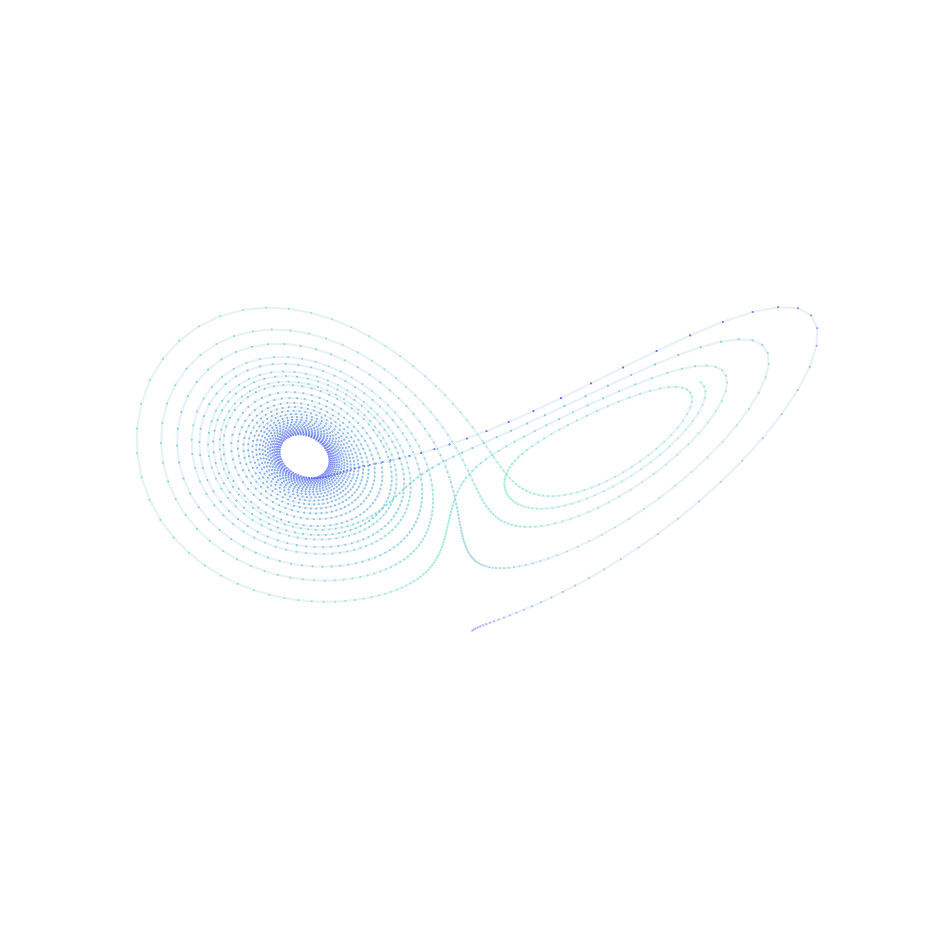

In [109]:
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D


def lorentz(sigma=10, beta=8 / 3, rho=28, dt=0.01, T=20):
    def f(state, t):
        x, y, z = state  # Unpack the state vector
        return sigma * (y - x), x * (rho - z) - y, x * y - beta * z

    state0 = [1.0, 1.0, 1.0]
    t = np.arange(0.0, T, dt)
    states = odeint(f, state0, t)
    return states


def plot_trajectory(states):
    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes(projection="3d")
    c = np.linspace(0, 1, len(states))
    ax.scatter(states[:, 0], states[:, 1], states[:, 2], s=0.1, c=c, cmap="winter")
    ax.plot(states[:, 0], states[:, 1], states[:, 2], alpha=0.1)
    ax.set_axis_off()
    plt.show()


states = lorentz()
states -= states.mean()
states /= states.std()
plot_trajectory(states)

We'll create some noisy states and train a Kalman filter to smooth the data for us. Let's not make it too easy on our model!

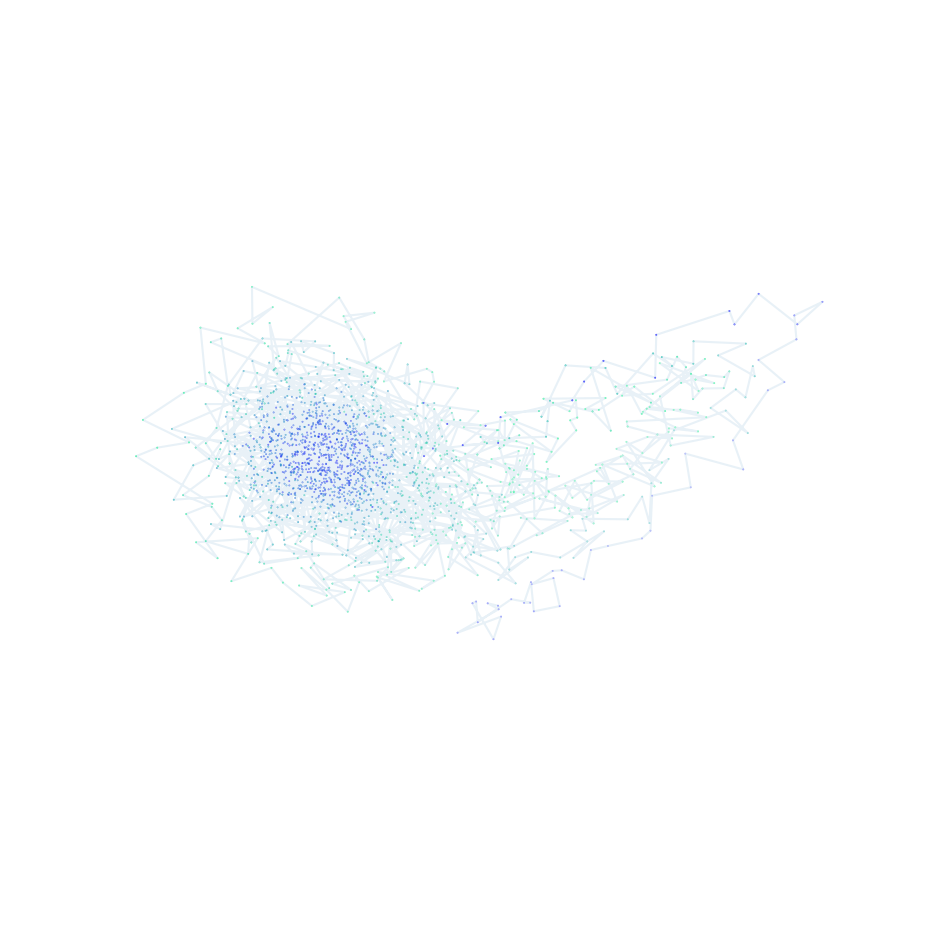

In [110]:
# Let's create some noisy states
noisy_states = states + np.random.normal(0, 0.1, size=states.shape)
plot_trajectory(noisy_states)

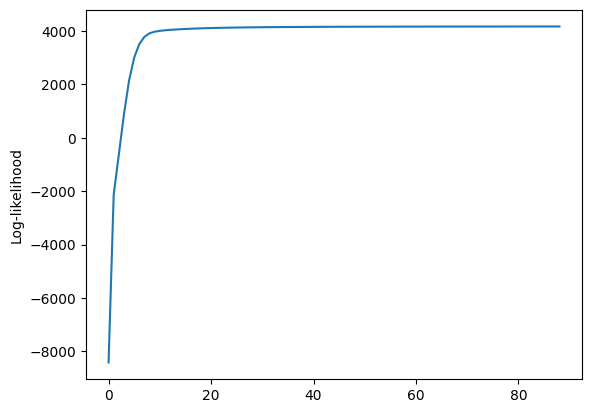

In [111]:
# This may take a while
kf = KalmanFilter(d_obs=3, d_latent=3)
LLs = kf.fit(noisy_states, tol=1e-1)

plt.plot(LLs)
plt.ylabel("Log-likelihood")
plt.show()

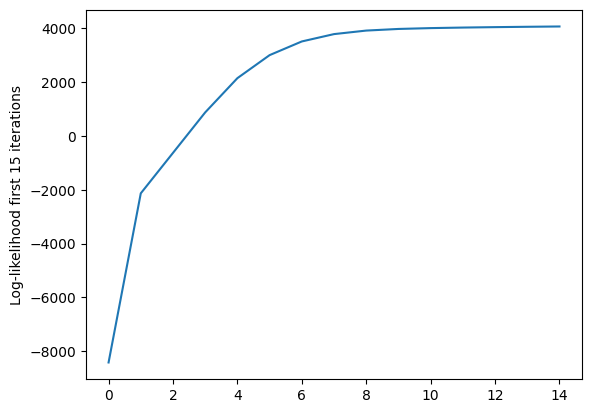

In [112]:
plt.plot(LLs[:15])
plt.ylabel("Log-likelihood first 15 iterations")
plt.show()

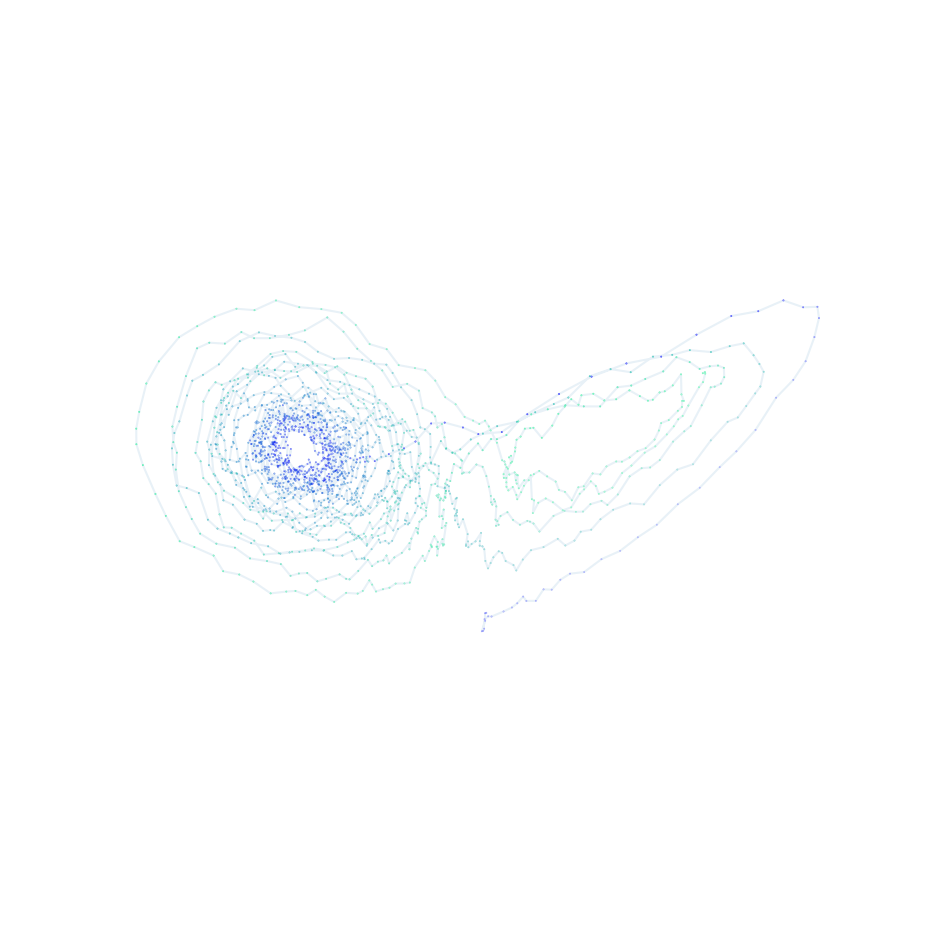

In [113]:
reconstruction = kf.smooth(noisy_states)
plot_trajectory(reconstruction)